<a href="https://colab.research.google.com/github/bingsen-wang/PowerElectronics/blob/main/PWM_TriangleVsSawtooth.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<center><h1><b>Pulse Width Modulation - Sine Triangle with Transitions Lined Up</h1></b>

Dr. Bingsen Wang

11/24/2023
</center>

#Python Code
The Python code illustrates the basic PWM.  

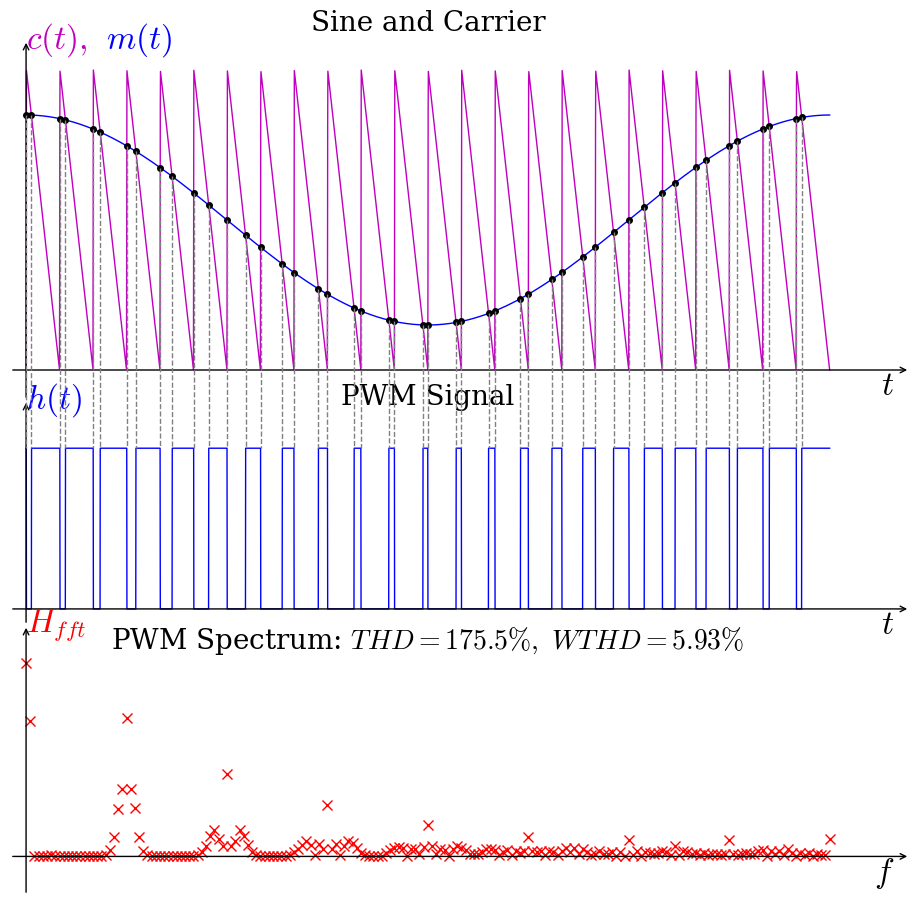

In [49]:
from os import linesep
from numpy import linspace,cos,pi,sin,heaviside,array,floor,fft,angle,abs,sqrt
from scipy.optimize import fsolve
import matplotlib.pyplot as plt
from matplotlib import animation,rc,lines
rc('animation', html='jshtml')
plt.rcParams.update({"font.family" : "serif","mathtext.fontset" : "cm"})

#functions
def carr(f,lmd,t): #general carrier
# lmd=0 -> falling sawthooth
# lmd=1 -> rising sawthooth
# lmd=0.5 -> triangle
  tr = t*fc-floor(t*fc)
  tf = 1-t*fc+floor(t*fc)
  if lmd==0:
    return tf
  elif lmd==1:
    return tr
  else:
    return (1/lmd*tr*heaviside(1-1/lmd*tr,1) +
            1/(1-lmd)*tf*heaviside(1-1/(1-lmd)*tf,0))

def m(MI,f,theta,t): #modulation function
  return (MI*cos(2*pi*f*t + theta) + 1)/2

def h(ct,mt): #PWM switching function
  return heaviside(mt-ct,0)

# define the function to be solved
def y(x,*data):
  MI,fm,theta,fc,lmd = data
  return m(MI,fm,theta,x) -carr(fc,lmd,x)

#solving for intersection points
def intersectionPoints(MI,fm,theta,fc,lmd):
  ts=[] #list for intersection points
  for k in range(fc):
    ts.append(fsolve(y,1/fc*(.5*lmd+k),args=(MI,fm,theta,fc,lmd))[0])
    ts.append(fsolve(y,1/fc*(0.5*(1+lmd)+k),args=(MI,fm,theta,fc,lmd))[0])
  ts=array(ts)
  mts = m(MI,fm,theta,ts) # m(t) values at intersection points
  return ts,mts

# draw dotted line between two sets of points in two different plots
def l2Ax(fig,ax1,ax2,ps1,ps2):
  line_set = []
  transFigure = fig.transFigure.inverted()
  for k in range(len(ps1[0])):
    p1 = transFigure.transform(ax1.transData.transform([ps1[0][k],ps1[1][k]]))
    p2 = transFigure.transform(ax2.transData.transform([ps2[0][k],ps2[1][k]]))
    line = lines.Line2D((p1[0],p2[0]),(p1[1],p2[1]),
                      transform=fig.transFigure,ls='--',color='gray', lw=1)
    line_set.append(line)
  fig.lines = line_set
  return

#spectrum
def spectrum(xt): #spectrum - magnitude and angle
  xfft = fft.rfft(xt)
  xfft_angle = angle(xfft)
  xfft_mag = abs(xfft)/len(xt)*2
  xfft_mag[0]=xfft_mag[0]*0.5 #adjust the dc component
  return xfft_mag,xfft_angle

#calculate total harmonic distortion thd
def thd(x):
  xhsq=0 #sum of harmonic squares
  for k in range(len(x)):
    if k>1:
      xhsq += x[k]**2
  return sqrt(xhsq)/x[1]

#calculate weighted total harmonic distortion wthd
def wthd(x):
  xhsq=0 #sum of harmonic squares
  for k in range(len(x)):
    if k>1:
      xhsq += (x[k]/k)**2
  return sqrt(xhsq)/x[1]

#parameters
Nf = 30 # number of frames
fc = 24 # carrier frequency
fm = 1 # signal
MI = 0.7 # modulation index
theta = 0
lmd = linspace(.01,.99,Nf)

#time series
t=linspace(0,1,4096)
mt = m(MI,fm,0,t) #modulation function time series

#spectrum and frequency series
fser = linspace(0,1,int(fc*8)+1) #frequency series for plotting

#set up figures
fig = plt.figure(figsize=(9,9))
fig.tight_layout()
ax_frame = [[[0, 0.55, 1, .4], [-.02,1.1], [-.1,1.1]], #sine & general carrier
            [[0, .3,   1, .25], [-.02,1.1], [-.1,1.3]], # pwm
            [[0, 0,   1, .3], [-.02,1.1], [-.1,.6]], # pwm spectrum
            ]# [pos-boundary, xlim, ylim] for subplots
ax_lbl=[[['$c(t),$','$m(t)$'], '$t$'], [['$h(t)$'], '$t$'],[['$H_{fft}$'],'$f$']] #yx axes labels
clst=[['m','b'],['b'],['r']] #colors of lines
ax_lst=[] #axis list or the list of subplots
lines_lst = [] #array for all lines
for k in range(len(ax_frame)):
  xn,xm,yn,ym = ax_frame[k][1]+ax_frame[k][2]
  ax=fig.add_axes(ax_frame[k][0],xlim=[xn,xm], ylim=[yn,ym],fc='none') #no fc
  ax.axis('off') #turn off axis frames
  ax_lst.append(ax)
  ax.annotate("", (xm, 0), (xn, 0),arrowprops={'arrowstyle':"->"}) #x-axis
  ax.annotate("", (0,ym), (0,yn),arrowprops={'arrowstyle':"->"}) #y-axis
  for kk in range(len(ax_lbl[k][0])):
    lines_lst.append(ax.plot([], [], clst[k][kk], lw=1)[0]) #triangle carrier
    y_text=ax.text(0.1*kk,ym,ax_lbl[k][0][kk],size=24,va='center',color=clst[k][kk]) #y label
  if k==0:
    lines_lst.append(ax.plot([], [], color='k', ls='',marker='o',markersize=4)[0]) #intersection points
  if k==2:
    lines_lst.append(ax.plot([], [], clst[k][0], ls='',marker='x',markersize=7)[0]) #triangle carrier
  ax.text(xm-.02,0,ax_lbl[k][-1],size=24,va='top',ha='right') #x-axis label


ax_lst[0].text(0.5,ax_frame[0][2][1]+0.1,'Sine and Carrier',va='top',ha='center',size=20)
ax_lst[1].text(0.5,ax_frame[1][2][1]+0.1,'PWM Signal',va='top',ha='center',size=20)
tx_title=ax_lst[2].text(0.5,ax_frame[2][2][1],'',va='top',ha='center',size=20)

# for k in range(len(ts)):
#   l2Ax(fig,[ts[k],mts[k]],[ts[k],1])
# animation function. This is called sequentially
def animate(i):
  ct = carr(fc,lmd[i],t) #carrier time-domain signal
  ht = h(ct,mt)
  hfft=spectrum(ht)
  thd_h = thd(hfft[0])
  wthd_h = wthd(hfft[0])
  ts,mts = intersectionPoints(MI,fm,theta,fc,lmd[i]) #intersection points
  lines_lst[0].set_data(t,ct)
  lines_lst[1].set_data(t,mt)
  lines_lst[2].set_data(ts,mts)
  lines_lst[3].set_data(t,ht)
  lines_lst[5].set_data(fser,hfft[0][:len(fser)]) #ac spectrum
  l2Ax(fig, ax_lst[0], ax_lst[1],[ts,mts],[ts,ts*0+1]) # draw the dotted lines
  tx_title.set_text('PWM Spectrum: $THD=' +str(round(thd_h*100,1)) +'\%,\ WTHD='+str(round(wthd_h*100,2))+'\%$')
  return

anim = animation.FuncAnimation(fig, animate, frames=Nf, interval=50)
# anim #uncomment to generate animation in the output area
# to save the animation, uncomment the following three lines
fn = r"PWM_sineTriangleVsSawtooth.mp4"
writervideo = animation.FFMpegWriter(fps=2)
anim.save(fn, writer=writervideo,dpi = 120)